In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

IMAGES_PATH = Path("./figure/linear_models")  # 设置图像保存路径
IMAGES_PATH.mkdir(parents=True, exist_ok=True)  # 创建文件夹

def save_fig(fname, tight_layout=True, fig_extension='png', resolution=300):
    path = IMAGES_PATH.joinpath(fname + '.' + fig_extension)
    print(f"Save figure in '{path}'")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 1.线性回归
#### 标准方程求闭解
构造出带有偏置项的特征矩阵 $X$ 后，通过闭解式得到最优的参数向量：$\hat{\boldsymbol{\theta}} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}$.

- `np.ones((n, m))` 可以创建形状为 `(n, m)` 全为1的矩阵.
- `np.c_[a, b]` 可以将矩阵 `a,b` 按照列进行并排放置.
- `np.linalg.inv()` 可以求解逆矩阵.

Save figure in 'figure\linear_models\generated_linear_data.png'


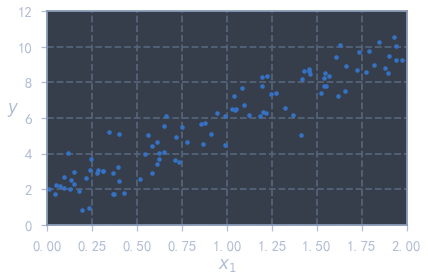

In [2]:
np.random.seed(42)
X = 2 * np.random.rand(100, 1)  # 在[0,2)之间均匀生成100个样本
np.random.seed(42)
y = 2 + 4 * X + np.random.randn(100, 1)  # 在线性函数2+4x的基础上加入高斯噪声

plt.plot(X, y, 'b.')
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 12])
save_fig("generated_linear_data")
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]  # 对每个样本加入偏置项, x0=1
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
print(theta_best)  # [[2.21509616] [3.77011339]] 与创建数据所用的 2+4x 比较接近

[[1.70655768]
 [4.20162012]]


Save figure in 'figure\linear_models\linear_model_predictions.png'


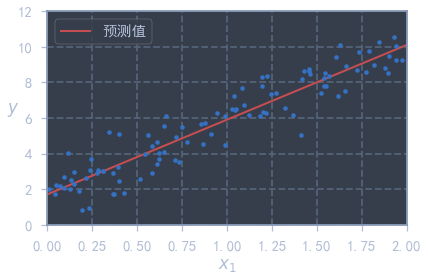

In [4]:
X_line = np.array([[0], [2]])
X_line_b = np.c_[np.ones((2, 1)), X_line]
y_predict = X_line_b @ theta_best

plt.plot(X_line, y_predict, 'r-', lw=2, label='预测值')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 12])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend()
save_fig("linear_model_predictions")
plt.show()

或者使用 `sklearn` 中的 `sklearn.linear_model.LinearRegression` 使用SVD分解方法求解 $\boldsymbol{X}^T\boldsymbol{X}$ 的伪逆.

通过调用 `intercept_` 获得截距（偏置项），`coef_` 获得系数.

而 `sklearn.linear_model.LinearRegression` 是基于 `np.linalg.lstsq()` 最小二乘函数得到的，也可通过 `np.linalg.pinv()` 直接计算伪逆.

In [5]:
from sklearn.linear_model import LinearRegression

line_reg = LinearRegression()
line_reg.fit(X, y)
print(line_reg.intercept_, line_reg.coef_)  # [2.21509616] [[3.77011339]]
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y)
print(theta_best_svd)  # [[2.21509616] [3.77011339]]
print(np.linalg.pinv(X_b) @ y)  # [[2.21509616] [3.77011339]]

[1.70655768] [[4.20162012]]
[[1.70655768]
 [4.20162012]]
[[1.70655768]
 [4.20162012]]


#### 梯度下降
$$
\nabla_{\theta_j}MSE(\boldsymbol{\theta}) = \frac{2}{m}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})x_{j}^{(i)} = \frac{2}{m}\boldsymbol{X}^T(\hat{\boldsymbol{y}}-\boldsymbol{y})
$$
##### 批量梯度下降(Batch Gradient Descent, BGD)

In [6]:
eta = 0.1  # 学习率
n_iterations = 1000  # 迭代次数
m = 100  # 训练集大小

np.random.seed(42)
theta = np.random.rand(2, 1)  # 随机初始化

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients
print(theta)  # [[2.21509616] [3.77011339]] 与闭解相同

[[1.70655768]
 [4.20162012]]


Save figure in 'figure\linear_models\bgd.png'


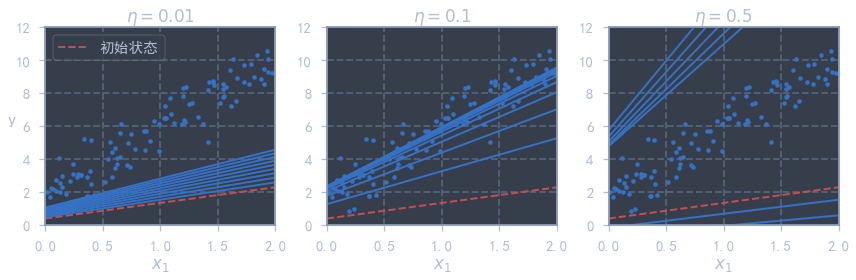

In [7]:
theta_path_bgd = []  # 存储BGD的theta变化
def plot_gradient_descent(theta, eta, theta_path=None):
    plt.plot(X, y, 'b.')
    for iteration in range(n_iterations):
        if theta_path is not None:
            theta_path.append(theta)
        if iteration < 10:
            y_line_predict = X_line_b @ theta
            linestyle = 'r--' if iteration == 0 else 'b-'
            label = '初始状态' if iteration == 0 else None
            plt.plot(X_line, y_line_predict, linestyle, label=label)
        gradients = 2/m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 12])
    plt.title(f"$\eta={eta}$")

np.random.seed(42)
theta = np.random.rand(2, 1)
plt.figure(figsize=(12, 4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.01); plt.legend()
plt.ylabel("y", rotation=0)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
save_fig("bgd")
plt.show()  # 可以看出不同的学习率的曲线收敛速度不同，当学习率太大会导致算法发散

##### 随机梯度下降(Stochastic Gradient Descent, SGD)

以一个样本计算梯度并进行更新，需要随迭代次数 $t$ 的增加逐渐降低学习率，使用以下方法计算学习率
$$
\eta(t) = \frac{t_0}{t_1+t}
$$
使用 [`sklearn.linear_model.SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) 可以便捷地达到相同的效果，其中也有学习率递降策略由 `learning_rate` 控制，由于未使用正则化项，所以令 `penalty=None`.

参数: [1.66908255 4.22999959]
Save figure in 'figure\linear_models\sgd.png'


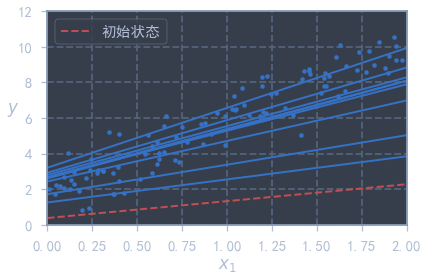

In [8]:
theta_path_sgd = []
n_epoch = 10
np.random.seed(42)
theta = np.random.rand(2, 1)
t0, t1 = 5, 50
def learning_schedule(t):
    return t0 / (t1 + t)

for epoch in range(n_epoch):
    for i in range(m):
        theta_path_sgd.append(theta)
        if epoch == 0 and i < 10:
            y_line_predict = X_line_b @ theta
            linestyle = 'r--' if i == 0 else 'b-'
            label = '初始状态' if i == 0 else None
            plt.plot(X_line, y_line_predict, linestyle, label=label)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
print("参数:", theta.reshape(-1))  # [2.19377016 3.87214289]

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 12])
plt.legend()
save_fig("sgd")
plt.show()

In [9]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y)
print(sgd_reg.intercept_, sgd_reg.coef_)  # [2.26548882] [3.80567955]

[1.76344097] [4.2692781]


##### 小批量梯度下降(Mini-batch gradient descent, Mini-BGD)

In [10]:
theta_path_mbgd = []
n_epoch = 200
batch_size = 20
np.random.seed(42)
theta = np.random.rand(2, 1)
t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t1 + t)

for epoch in range(n_epoch):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, batch_size):
        theta_path_mbgd.append(theta)
        xi = X_b[i:i+batch_size+1]
        yi = y[i:i+batch_size+1]
        gradients = 2/batch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * (m // batch_size) + i)
        theta = theta - eta * gradients
print("参数:", theta.reshape(-1))  # [2.21497588 3.89786208]

参数: [1.74509663 4.19625375]


In [11]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mbgd = np.array(theta_path_mbgd)

Save figure in 'figure\linear_models\gradient_descent_paths.png'


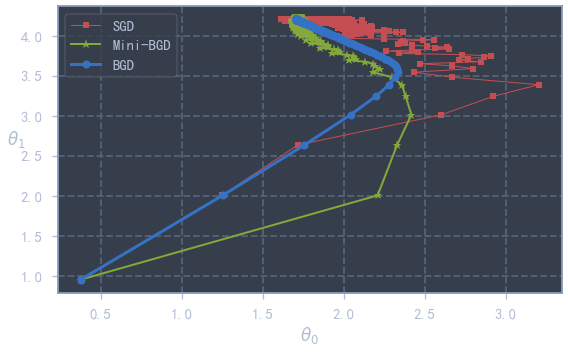

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(theta_path_sgd[:, 0], theta_path_bgd[:, 1], 'r-s', markersize='6', lw=1, label="SGD")
plt.plot(theta_path_mbgd[:, 0], theta_path_bgd[:, 1], 'g-*', lw=2, label="Mini-BGD")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], 'b-o', markersize='8',lw=3, label="BGD")
# plt.axis([1.5, 3.2, 2.4, 3.9])
plt.legend()
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$", rotation=0)
save_fig("gradient_descent_paths")
plt.show()  # 从下图可以看出BGD的方差是最小的最稳定，而SGD最不稳定

### 2.多项式回归

In [13]:
m = 100
np.random.seed(42)
X = 4 * np.random.rand(m, 1) - 2
np.random.seed(42)
y = 8 + 2* X - X**2 + np.random.randn(m, 1)

Save figure in 'figure\linear_models\generated_quadratic_data.png'


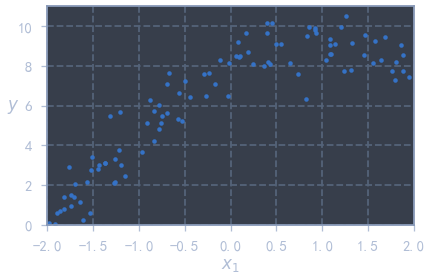

In [14]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-2, 2, 0, 11])
save_fig("generated_quadratic_data")
plt.show()

使用 `sklearn.preprocessing.PolynomialFeatures(degree, include_bias=False)` 可以生成最大幂次为 `degree` 的全部特征组合，`include_bias=False` 表示不包含偏置项，在线性回归的时候默认带了偏置，此处就无须该项.

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(f"{X[0]} -> {X_poly[0]}")  # [-0.50183952] -> [-0.50183952  0.25184291]
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)  # [7.96332948] [[ 2.09663123 -1.03929909]] 与真实值 8 2 -1 相差很小

[-0.50183952] -> [-0.50183952  0.25184291]
[7.96332948] [[ 2.09663123 -1.03929909]]


Save figure in 'figure\linear_models\quadratic_predictions.png'


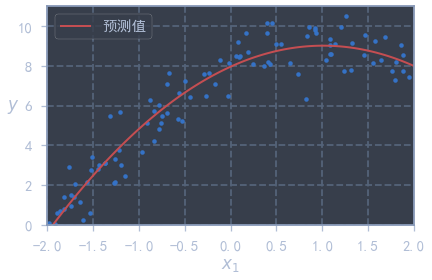

In [16]:
X_new = np.linspace(-2, 2, 100).reshape(100, 1)  # 在[-2,2]上等距取100个点
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-', lw=2, label="预测值")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-2, 2, 0, 11])
plt.legend()
save_fig("quadratic_predictions")
plt.show()

使用 `sklearn.preprocessing.StandardScaler` 进行标准化处理，`sklearn.pipeline.Pipeline` 生成数据预处理和模型训练的流水线.

Save figure in 'figure\linear_models\high_degree_polynoimals.png'


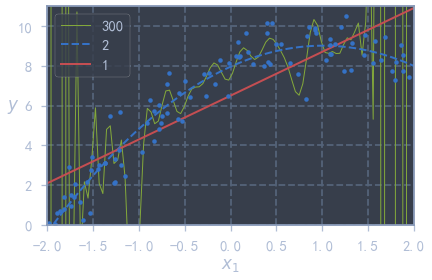

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, linewidth, degree in (('g-', 1, 300), ('b--', 2, 2), ('r-', 2, 1)):
    polynomial_pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("lin_reg", LinearRegression())
    ])
    polynomial_pipeline.fit(X, y)
    y_new = polynomial_pipeline.predict(X_new)
    plt.plot(X_new, y_new, style, lw=linewidth, label=str(degree))
    
plt.plot(X, y, 'b.')
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-2, 2, 0, 11])
save_fig("high_degree_polynoimals")
plt.show()

### 正则化线性模型
#### 岭回归

使用 `sklearn.linear_model.Ridge(alpha)` 可以实现岭回归，使用 $l_2$ 正则项，其中 `alpha` 是正则化系数.

In [18]:
m = 20
np.random.seed(42)
X = 3 * np.random.rand(m, 1)
np.random.seed(42)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

Save figure in 'figure\linear_models\ridge_regression.png'


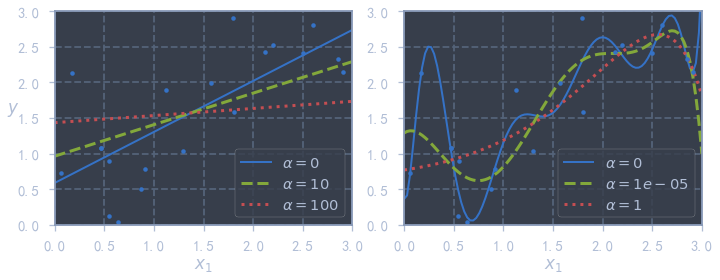

In [19]:
from sklearn.linear_model import Ridge

def plot_model_curve(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("regular_reg", model)
            ])
        model.fit(X, y)
        y_new = model.predict(X_new)
        linewidth = 2 if alpha == 0 else 3
        plt.plot(X_new, y_new, style, lw=linewidth, label=f"$\\alpha={alpha}$")
    plt.plot(X, y, 'b.')
    plt.legend(loc="lower right")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3])
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_model_curve(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model_curve(Ridge, polynomial=True, alphas=(0, 1e-5, 1), random_state=42)
save_fig("ridge_regression")
plt.show()  # 从下图中可以看出，正则项越大，曲线斜率越小，更加平缓

#### Lasso回归
使用 `sklearn.linear_model.Lasso` 实现Lasso回归，使用 $l_1$ 正则项，用法与 `Ridge` 类似.

Save figure in 'figure\linear_models\lasso_regression.png'


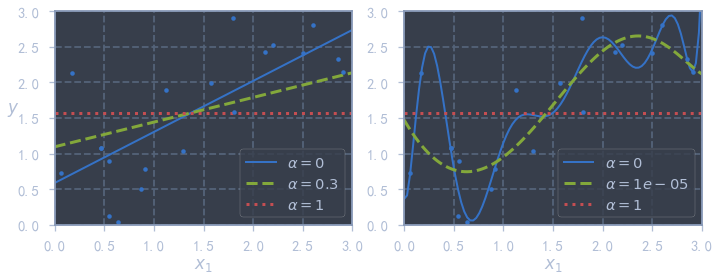

In [20]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_model_curve(Lasso, polynomial=False, alphas=(0, 0.3, 1), random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model_curve(Lasso, polynomial=True, alphas=(0, 1e-5, 1), random_state=42)
save_fig("lasso_regression")
plt.show()  # 与岭回归进行对比，可以发现相同的正则系数下，Lasso回归的曲线更加平缓，对参数抑制更强
# 而且alpha不能太大，否则模型参数全部抑制为0了

#### 弹性网络

使用 `sklearn.linear_model.ElasticNet(l1_ratio)` 实现弹性网络，其中 `l1_ratio` 表示 $l_1$ 范数所占的权重，正则化项的具体表示形式如下：
$$
\alpha \left(l_{1_{ratio}} ||w||_1 + \frac{1}{2} (1 - l_{1_{ratio}})||w||^2_2\right)
$$

Save figure in 'figure\linear_models\elasticnet_regression.png'


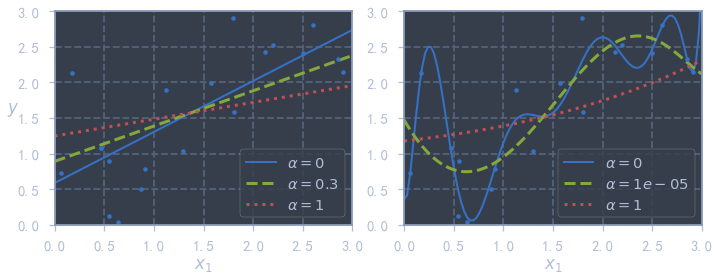

In [21]:
from sklearn.linear_model import ElasticNet

plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_model_curve(ElasticNet, polynomial=False, alphas=(0, 0.3, 1), l1_ratio=0.2, random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model_curve(ElasticNet, polynomial=True, alphas=(0, 1e-5, 1), l1_ratio=0.2, random_state=42)
save_fig("elasticnet_regression")
plt.show()  # 而弹性网络则是对上述两者的综合

In [22]:
theta1_a, theta1_b, theta2_a, theta2_b = -1, 3, -1.5, 1.5  # 设定参数的取值范围
theta1_linspace = np.linspace(theta1_a, theta1_b, 500)  # 获取theta1的均匀插值点
theta2_linspace = np.linspace(theta2_a, theta2_b, 500)  # 获取theta2的均匀插值点
theta1, theta2 = np.meshgrid(theta1_linspace, theta2_linspace)  # 网格化对应(theta1, theta2)，得到参数向量
Theta = np.c_[theta1.ravel(), theta2.ravel()]  # 构造参数矩阵Theta

X = np.array([[1, -1], [1, 0.5], [1, 1]])  # 构造训练样本特征
y = 2 * X[:, :1] + 1 * X[:, 1:]  # 以函数y=2+x生成对应标签
m = len(X)  # 训练集大小

# 求解每个(theta1,theta2)对应的不带正则项的成本函数值
J = (1/m * np.sum((X @ Theta.T - y) ** 2, axis=0)).reshape(theta1.shape)

N1 = np.linalg.norm(Theta, ord=1, axis=1).reshape(theta1.shape)  # 求解每个(theta1,theta2)对应的l1范数
N2 = np.linalg.norm(Theta, ord=2, axis=1).reshape(theta1.shape)  # 求解每个(theta1,theta2)对应的l2范数

theta_min_index = np.unravel_index(np.argmin(J), J.shape)  # 求最小值对应的下标
theta1_min, theta2_min = theta1[theta_min_index], theta2[theta_min_index]  # 最优参数[1.998, 0.502]
theta_init = np.array([[0], [-1]])  # 初始参数向量

Save figure in 'figure\linear_models\lasso_vs_ridge.png'


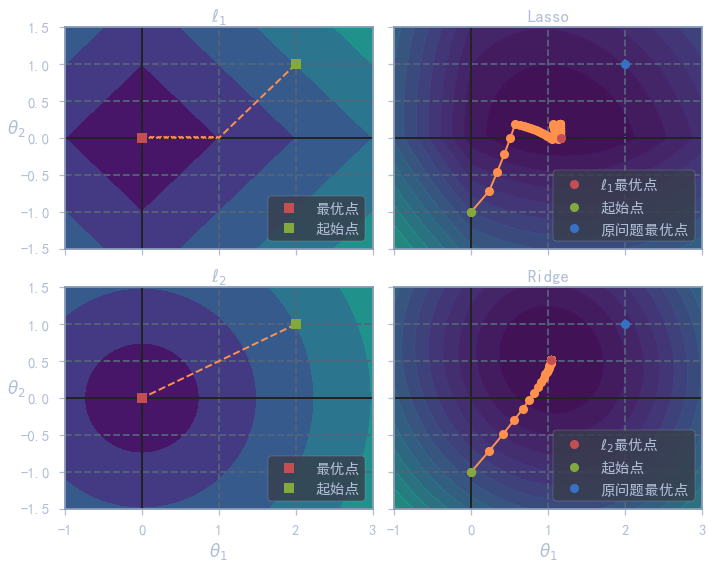

In [23]:
# 使用批量梯度下降BGD，并用list返回参数变化，l1，l2分别表示l1和l2正则化系数，core=0表示最小化参数范数(原点处最小)
def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    theta_path = [theta]  # 先存储theta初始值
    for i in range(n_iterations):
        gradients = core * 2/m * X.T @ (X @ theta - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        theta_path.append(theta)
    return np.array(theta_path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))  # 构造2x2的画板，共享x,y轴
for i, N, l1, l2, title in ((0, N1, 2, 0, "Lasso"), (1, N2, 0, 2, "Ridge")):  # 按行绘制图像，分别绘制l1范数和l2范数对应轨迹
    JR = J + l1 * N1 + l2 * 0.5 * N2**2  # 计算带有正则项的成本函数
    
    theta_regular_index = np.unravel_index(np.argmin(JR), JR.shape)  # 求出在正则化之后最小值对应下标
    theta1_regular_min, theta2_regular_min = theta1[theta_regular_index], theta2[theta_regular_index]
    
    levelsJ = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J) # 构造J的等高线，使用指数分布采样
    levelsJR = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR) # 构造JR的等高线，使用指数分布采样
    levelsN = np.linspace(0, np.max(N), 10)  # 构造参数范数的等高线，均匀采样

    path_J = bgd_path(theta_init, X, y, l1=0, l2=0)  # 不使用正则化项
    path_JR = bgd_path(theta_init, X, y, l1, l2)  # 使用对应正则化项
    path_N = bgd_path(np.array([[2], [1]]), X, y, l1/6, l2, core=0)  # 从(2,0.5)开始，最小化范数
    
    ax = axes[i, 0]
    ax.axhline(y=0, color='k')  # 绘制y轴
    ax.axvline(x=0, color='k')  # 绘制x轴
    ax.contourf(theta1, theta2, N/2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], 'y--')
    ax.plot(0, 0, 'rs', label='最优点')
    ax.plot([2], [1], "gs", label='起始点')
    ax.set_title(f"$\\ell_{i+1}$")
    ax.axis([theta1_a, theta1_b, theta2_a, theta2_b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)
    ax.legend()
    
    ax = axes[i, 1]
    ax.axhline(y=0, color='k')  # 绘制y轴
    ax.axvline(x=0, color='k')  # 绘制x轴
    ax.contourf(theta1, theta2, JR, levels=levelsJR, alpha=0.8)
    ax.plot(path_JR[:, 0], path_JR[:, 1], 'y-o')
    ax.plot(theta1_regular_min, theta2_regular_min, 'ro', label=f'$\\ell_{i+1}$最优点')
    ax.plot(theta_init[0], theta_init[1], "go", label='起始点')
    ax.set_title(title)
    ax.axis([theta1_a, theta1_b, theta2_a, theta2_b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.plot(theta1_min, theta2_min, 'bo', label='原问题最优点')
    ax.legend()
save_fig("lasso_vs_ridge")
plt.show()  # 从下图中可以看出Lasso回归中theta2几乎为0
# 由于原始最优解theta2<theta1，所以x1相对x0权重较低，Lasso回归中直接将其置为0

Save figure in 'figure\linear_models\BGD_without_regular.png'


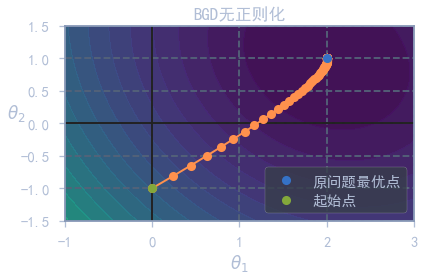

In [24]:
plt.axhline(y=0, color='k')  # 绘制y轴
plt.axvline(x=0, color='k')  # 绘制x轴
plt.contourf(theta1, theta2, J, levels=levelsJ, alpha=0.8)
plt.plot(path_J[:, 0], path_J[:, 1], 'y-o')
plt.plot(theta1_min, theta2_min, 'bo', label='原问题最优点')
plt.plot(theta_init[0], theta_init[1], "go", label='起始点')
plt.title("BGD无正则化")
plt.axis([theta1_a, theta1_b, theta2_a, theta2_b])
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$", rotation=0)
plt.legend()
save_fig("BGD_without_regular")
plt.show()

### 3.Logistic回归
使用经典Iris数据集，包含150个鸢尾花，来自三个不同品种（山鸢尾，变色鸢尾，弗吉尼亚鸢尾），数据特征属性总共4个，分别为包含萼片的长度与宽度，花瓣的长度和宽度.

先使用花边宽度单个属性值对品种是否是弗吉尼亚鸢尾花进行预测，再使用花瓣宽度和长度两个属性值进行预测，分别绘制出决策边界和样本点图像.

使用 `sklearn.linear_model.LogisticRegression(C)` 实现Logistic回归，默认使用 $l_2$ 正则化项，正则化系数为 $1/C$，如果不想使用正则化，可将 $C$ 设置为较大值.

In [25]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
print(iris.DESCR)  # 查看该数据集的相关信息
print(iris.keys())  # 通过关键词索引可以获取数据集中的信息
X = iris['data'][:, 3:]  # 花瓣宽度
y = (iris['target']==2).astype(np.int)  # 弗吉尼亚鸢尾
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

LogisticRegression(random_state=42)

Save figure in 'figure\linear_models\logistic_regression.png'


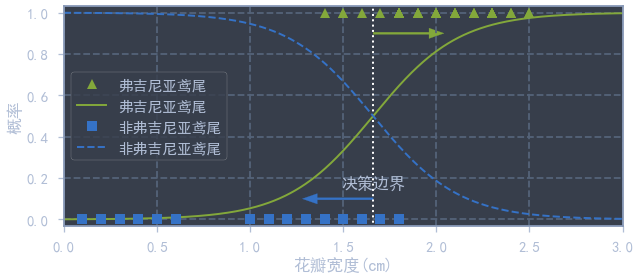

In [26]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_new_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_new_proba[:, 1] >= 0.5][0]  # 决策边界

plt.figure(figsize=(9, 4))
plt.plot(X[y==1], y[y==1], 'g^', label='弗吉尼亚鸢尾')
plt.plot([decision_boundary, decision_boundary], [-1, 2], 'w:', lw=2)
plt.plot(X_new, y_new_proba[:, 1], 'g-', label='弗吉尼亚鸢尾')
plt.plot(X[y==0], y[y==0], 'bs', label='非弗吉尼亚鸢尾')
plt.plot(X_new, y_new_proba[:, 0], 'b--', label='非弗吉尼亚鸢尾')
plt.text(decision_boundary, 0.15, '决策边界', fontsize=16, ha='center')
plt.arrow(decision_boundary, 0.1, -0.3, 0, head_width=0.05, head_length=0.08, width=0.01, fc='b', ec='b')
plt.arrow(decision_boundary, 0.9, 0.3, 0, head_width=0.05, head_length=0.08, width=0.01, fc='g', ec='g')
plt.xlabel("花瓣宽度(cm)")
plt.ylabel("概率")
plt.axis([0, 3, -0.03, 1.03])
plt.legend(loc='center left')
save_fig('logistic_regression')
plt.show()

Save figure in 'figure\linear_models\logistic_regression_contour.png'


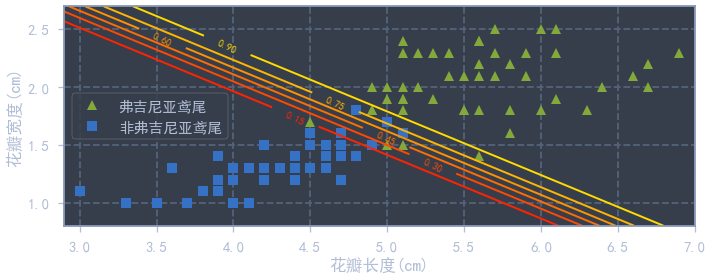

In [27]:
X = iris['data'][:, (2,3)]  # 获取花瓣的长度和宽度
y = (iris['target'] == 2).astype(np.int)  # 判断是否为弗吉尼亚鸢尾

log_reg = LogisticRegression(C=1e10, random_state=42)  # 不使用正则化
log_reg.fit(X, y)

x0, x1 = np.meshgrid(  # 网格化
    np.linspace(2.9, 7, 500),
    np.linspace(0.8, 2.7, 200)
)
X_new = np.c_[x0.ravel(), x1.ravel()]  # 网格化数据集
y_new_proba = log_reg.predict_proba(X_new)  # 计算网格点概率

plt.figure(figsize=(10, 4))
plt.plot(X[y==1, 0], X[y==1, 1], 'g^', label='弗吉尼亚鸢尾')
plt.plot(X[y==0, 0], X[y==0, 1], 'bs', label='非弗吉尼亚鸢尾')
z = y_new_proba[:, 1].reshape(x0.shape)  # 每个网格点预测为真的概率
contour = plt.contour(x0, x1, z, cmap='autumn')  # 绘制等高线(等概率线)
plt.clabel(contour, inline=1)  # 在等高线上写对应概率
plt.axis([2.9, 7, 0.8, 2.7])
plt.xlabel("花瓣长度(cm)")
plt.ylabel("花瓣宽度(cm)")
plt.legend(loc='center left')
save_fig("logistic_regression_contour")
plt.show()

### 4.Softmax回归
也是使用 `sklearn.linear_model.LogisticRegression(multi_class='multinomial')`，只需将 `multi_class` 设置为 `multinomial` 即可使用Softmax回归求解多分类任务（否则可能使用“一对多(OvR)”分类策略）

特征属性仍然选取两个属性：花瓣长度，花瓣宽度. 分类目标为三种鸢尾花，绘制预测为“变色鸢尾”的等概率边界线.

Save figure in 'figure\linear_models\softmax_regression_contour.png'


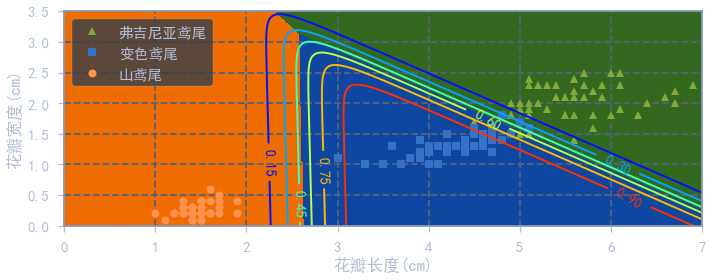

In [28]:
X = iris['data'][:, (2,3)]  # 获取花瓣的长度和宽度
y = iris['target']

log_reg = LogisticRegression(multi_class='multinomial', C=10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(  # 网格化
    np.linspace(0, 8, 500),
    np.linspace(0, 3.5, 200)
)
X_new = np.c_[x0.ravel(), x1.ravel()]  # 网格化数据集
y_new_prob = log_reg.predict_proba(X_new)  # 计算网格点概率
y_new_pred = log_reg.predict(X_new)  # 计算网格点预测结果

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], 'g^', markersize=8, label='弗吉尼亚鸢尾')
plt.plot(X[y==1, 0], X[y==1, 1], 'bs', markersize=8, label='变色鸢尾')
plt.plot(X[y==0, 0], X[y==0, 1], 'yo', markersize=8, label='山鸢尾')
z_prob = y_new_prob[:, 1].reshape(x0.shape)  # 获取预测为"变色鸢尾"的概率
z_cate = y_new_pred.reshape(x0.shape)  # 用于绘制区块颜色

custom_cmap = mpl.colors.ListedColormap(['#EF6C00', '#0D47A1', '#33691E'])  # 自定义cmap颜色谱
plt.contourf(x0, x1, z_cate, cmap=custom_cmap)

contour = plt.contour(x0, x1, z_prob, cmap='jet')
plt.clabel(contour, inline=1, fontsize=14)
plt.xlabel('花瓣长度(cm)')
plt.ylabel('花瓣宽度(cm)')
plt.legend()
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour")
plt.show()